In this tutorial, we will train a Spiking Neural Network to perform digit recognition on the MNIST dataset. We will use the [SuperSpike](https://www.mitpressjournals.org/doi/pdf/10.1162/neco_a_01086) learning rule to do this.

In [20]:
from mlxtend.data import loadlocal_mnist
from sklearn.preprocessing import minmax_scale
import numpy as np
import os
import pickle as pkl
from pygenn import genn_wrapper
from pygenn import genn_model
import matplotlib.pyplot as plt
from utils import create_poisson_spikes, get_mean_square_error
from models.neurons.lif_superspike import (output_model_classification, OUTPUT_PARAMS, output_init_classification,
                                           hidden_model, HIDDEN_PARAMS, hidden_init,
                                           feedback_postsyn_model)
from models.synapses.superspike import (superspike_model, SUPERSPIKE_PARAMS, superspike_init,
                                        feedback_wts_model, feedback_wts_init)

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ["CUDA_PATH"] = "/usr/local/cuda-11.0"

import warnings
warnings.filterwarnings('ignore')

# Setting up the dataset

Before we can use a SNN on the MNIST dataset, we will convert the samples from the MNIST dataset into spike latency values using the method described in [this paper](https://www.biorxiv.org/content/10.1101/2020.06.29.176925v1). This means that for every sample, the pixel values will be converted into firing times such that each of the 784 input neurons spike exactly once during a sample presentation.

In [2]:
# function to change a vector of pixel values to a vector of latency-to-spike times
def to_spike_latency(img_vec, t_eff, thresh):
    img_vec = img_vec.flatten()
    norm_img_vec = minmax_scale(img_vec, feature_range=(0, t_eff - 1))
    spike_img_vec = np.where(norm_img_vec > thresh,
                             t_eff * np.log(norm_img_vec / (norm_img_vec - thresh)),
                             np.inf)
    return spike_img_vec

Below, we initialize a data structure to store the spike times for each pixel for each sample. We will populate `X_train_spike`, of size rows=60,000 and cols=784, with values corresponding to the latency-to-spike time for each pixel. Note that many values in this data structure will be `np.inf`, meaning that these input neurons should not spike during sample presentation. We will also do the same for the testing set. We round up the spike times to one decimal place because we will use a timestep of 0.1 ms in the simulation of our network.

In [2]:
data_dir = "./mnist"
T_EFF = 50  # ms
THRESH = 0.2
N_INPUT = 784

In [3]:
# Process MNIST training dataset
# X_train, y_train = loadlocal_mnist(
#     images_path=os.path.join(data_dir, 'train-images-idx3-ubyte'),
#     labels_path=os.path.join(data_dir, 'train-labels-idx1-ubyte'))
# 
# X_train_spike = np.zeros(shape=X_train.shape)

# for img_idx in range(X_train.shape[0]):
#     if img_idx % 5000 == 0:
#         print("Processing img " + str(img_idx))
#     img = X_train[img_idx, :]
#     X_train_spike[img_idx, :] = to_spike_latency(img, T_EFF, THRESH)

# X_train_spike = np.round(X_train_spike, decimals=1)
# print("Training set size: " + str(X_train_spike.shape))

_, y_train = loadlocal_mnist(
    images_path=os.path.join(data_dir, 'train-images-idx3-ubyte'),
    labels_path=os.path.join(data_dir, 'train-labels-idx1-ubyte'))

In [26]:
# Process MNIST testing dataset
# X_test, y_test = loadlocal_mnist(
#     images_path=os.path.join(data_dir, 't10k-images-idx3-ubyte'),
#     labels_path=os.path.join(data_dir, 't10k-labels-idx1-ubyte'))

# X_test_spike = np.zeros(shape=X_test.shape)

# for img_idx in range(X_test.shape[0]):
#     if img_idx % 1000 == 0:
#         print("Processing img " + str(img_idx))
#     img = X_test[img_idx, :]
#     X_test_spike[img_idx, :] = to_spike_latency(img, T_EFF, THRESH)

# X_test_spike = np.round(X_test_spike, decimals=1)
# print("Testing set size: " + str(X_test_spike.shape))

_, y_test = loadlocal_mnist(
    images_path=os.path.join(data_dir, 't10k-images-idx3-ubyte'),
    labels_path=os.path.join(data_dir, 't10k-labels-idx1-ubyte'))

Now that we have our data in the right format, we can start setting up our network. Before building the model, we need to decide on how our trials shoud be structured. Following the trial design of XOR from SuperSpike, our trials will be comprised of three phases: sample presentation, waiting period (15 ms) and intertrial interval (50 ms). The length of the first phase will be set to the maximum finite spike latency of all samples.

In [4]:
# MAX_TIMESTEPS_TRAIN = np.ceil(np.amax(X_train_spike, where=~np.isinf(X_train_spike), initial=-1))  # ms
# MAX_TIMESTEPS_TEST = np.ceil(np.amax(X_test_spike, where=~np.isinf(X_test_spike), initial=-1))  # ms
# STIMULUS_TIMESTEPS = np.amax([MAX_TIMESTEPS_TEST, MAX_TIMESTEPS_TRAIN])  # ms
STIMULUS_TIMESTEPS = 37
print("Stimulus timesteps: " + str(STIMULUS_TIMESTEPS))
ITI = 50  # ms
WAIT_TIMESTEPS = 15  # ms
total_time = STIMULUS_TIMESTEPS + WAIT_TIMESTEPS + ITI 

Stimulus timesteps: 37


Also similar to the XOR task, we need to preprocess our samples into trials. We will use 5 epochs to train our networks.

In [7]:
def create_trials(n_neurons, epochs, n_samples, sample_spike, stimulus_timesteps, 
                  wait_timesteps, iti, wait_freq, spike_dt, time_factor):
    poisson_spikes = []

    for neuron_idx in range(n_neurons):
        if neuron_idx % 10 == 0:
            print("Processing neuron " + str(neuron_idx))
        neuron_poisson_spikes = np.empty(0)
        time_elapsed = 0
        for epoch in range(epochs):
            for trial_idx in range(n_samples):
                sample_spike_time = sample_spike[trial_idx, neuron_idx]
                if not np.isinf(sample_spike_time):
                    sample_spike_time += time_elapsed
                    neuron_poisson_spikes = np.hstack((neuron_poisson_spikes, sample_spike_time))
                time_elapsed += stimulus_timesteps

                wait_plus_iti = wait_timesteps + iti
                wait_spike_times = create_poisson_spikes(wait_plus_iti, wait_freq, spike_dt, time_factor)
                wait_spike_times += time_elapsed
                neuron_poisson_spikes = np.hstack((neuron_poisson_spikes, wait_spike_times))
                time_elapsed += wait_plus_iti

        poisson_spikes.append(neuron_poisson_spikes)

    spike_counts = [len(n) for n in poisson_spikes]
    end_spike = np.cumsum(spike_counts)
    start_spike = np.empty_like(end_spike)
    start_spike[0] = 0
    start_spike[1:] = end_spike[0:-1]

    spikeTimes = np.hstack(poisson_spikes).astype(float)
    
    return start_spike, end_spike, spikeTimes

In [5]:
WAIT_FREQ = 1  # Hz
spike_dt = 0.001

TIME_FACTOR = 0.1

TRAIN_SAMPLES = 60000
TEST_SAMPLES = 10000
TRAIN_EPOCHS = 5

In [11]:
train_start_spike, train_end_spike, train_spikeTimes = create_trials(N_INPUT, TRAIN_EPOCHS, TRAIN_SAMPLES, 
                                                                     X_train_spike, STIMULUS_TIMESTEPS, 
                                                                     WAIT_TIMESTEPS, ITI, WAIT_FREQ, 
                                                                     spike_dt, TIME_FACTOR)

test_start_spike, test_end_spike, test_spikeTimes = create_trials(N_INPUT, 1, TEST_SAMPLES,
                                                                  X_test_spike, STIMULUS_TIMESTEPS,
                                                                  WAIT_TIMESTEPS, ITI, WAIT_FREQ, 
                                                                  spike_dt, TIME_FACTOR)

Processing neuron 0
Processing neuron 10
Processing neuron 20
Processing neuron 30
Processing neuron 40
Processing neuron 50
Processing neuron 60
Processing neuron 70
Processing neuron 80
Processing neuron 90
Processing neuron 100
Processing neuron 110
Processing neuron 120
Processing neuron 130
Processing neuron 140
Processing neuron 150
Processing neuron 160
Processing neuron 170
Processing neuron 180
Processing neuron 190
Processing neuron 200
Processing neuron 210
Processing neuron 220
Processing neuron 230
Processing neuron 240
Processing neuron 250
Processing neuron 260
Processing neuron 270
Processing neuron 280
Processing neuron 290
Processing neuron 300
Processing neuron 310
Processing neuron 320
Processing neuron 330
Processing neuron 340
Processing neuron 350
Processing neuron 360
Processing neuron 370
Processing neuron 380
Processing neuron 390
Processing neuron 400
Processing neuron 410
Processing neuron 420
Processing neuron 430
Processing neuron 440
Processing neuron 450

In [14]:
with open("train_start_spike.pkl", "wb") as f:
    pkl.dump(train_start_spike, f)
with open("train_end_spike.pkl", "wb") as f:
    pkl.dump(train_end_spike, f)
with open("train_spikeTimes.pkl", "wb") as f:
    pkl.dump(train_spikeTimes, f)
    
with open("test_start_spike.pkl", "wb") as f:
    pkl.dump(test_start_spike, f)
with open("test_end_spike.pkl", "wb") as f:
    pkl.dump(test_end_spike, f)
with open("test_spikeTimes.pkl", "wb") as f:
    pkl.dump(test_spikeTimes, f)

In [6]:
# Load saved data
with open("train_start_spike.pkl", "rb") as f:
    train_start_spike = pkl.load(f)
with open("train_end_spike.pkl", "rb") as f:
    train_end_spike = pkl.load(f)
with open("train_spikeTimes.pkl", "rb") as f:
    train_spikeTimes = pkl.load(f)

In [18]:
# Load saved data
with open("test_start_spike.pkl", "rb") as f:
    test_start_spike = pkl.load(f)
with open("test_end_spike.pkl", "rb") as f:
    test_end_spike = pkl.load(f)
with open("test_spikeTimes.pkl", "rb") as f:
    test_spikeTimes = pkl.load(f)

# Defining the model

In [7]:
N_HIDDEN = 1024
N_OUTPUT = 10
update_time = 500  # ms

In [8]:
ssa_input_model = genn_model.create_custom_neuron_class(
    "ssa_input_model",
    param_names=["t_rise", "t_decay"],
    var_name_types=[("startSpike", "unsigned int"), ("endSpike", "unsigned int"),
                    ("z", "scalar"), ("z_tilda", "scalar")],
    sim_code="""
    // filtered presynaptic trace
    // $(z) *= exp(- DT / $(t_rise));
    $(z) += (- $(z) / $(t_rise)) * DT;
    $(z_tilda) += ((- $(z_tilda) + $(z)) / $(t_decay)) * DT;
    if ($(z_tilda) < 0.0000001) {
        $(z_tilda) = 0.0;
    }
    """,
    reset_code="""
    $(startSpike)++;
    $(z) += 1.0;
    """,
    threshold_condition_code="$(startSpike) != $(endSpike) && $(t)>= $(spikeTimes)[$(startSpike)]",
    extra_global_params=[("spikeTimes", "scalar*")],
    is_auto_refractory_required=False
)

SSA_INPUT_PARAMS = {"t_rise": 5, "t_decay": 10}

ssa_input_init = {"startSpike": train_start_spike,
                  "endSpike": train_end_spike,
                  "z": 0.0,
                  "z_tilda": 0.0}

In [9]:
TIME_FACTOR = 0.1

TRAIN_SAMPLES = 60000
TEST_SAMPLES = 10000
TRAIN_EPOCHS = 5

N_INPUT = 784

In [10]:
print("Building model...")

model = genn_model.GeNNModel(precision="float", model_name="train", time_precision="double")
model.dT = 1.0 * TIME_FACTOR

inp = model.add_neuron_population("inp", N_INPUT, ssa_input_model, SSA_INPUT_PARAMS, ssa_input_init)
inp.set_extra_global_param("spikeTimes", train_spikeTimes)

hid = model.add_neuron_population("hid", N_HIDDEN, hidden_model, HIDDEN_PARAMS, hidden_init)

out = model.add_neuron_population("out", N_OUTPUT, output_model_classification, OUTPUT_PARAMS,
                                  output_init_classification)

inp2hid = model.add_synapse_population("inp2hid", "DENSE_INDIVIDUALG", genn_wrapper.NO_DELAY,
                                       inp, hid,
                                       superspike_model, SUPERSPIKE_PARAMS, superspike_init, {}, {},
                                       "ExpCurr", {"tau": 5.0}, {})

hid2out = model.add_synapse_population("hid2out", "DENSE_INDIVIDUALG", genn_wrapper.NO_DELAY,
                                       hid, out,
                                       superspike_model, SUPERSPIKE_PARAMS, superspike_init, {}, {},
                                       "ExpCurr", {"tau": 5.0}, {})

out2hid = model.add_synapse_population("out2hid", "DENSE_INDIVIDUALG", genn_wrapper.NO_DELAY,
                                       out, hid,
                                       feedback_wts_model, {}, feedback_wts_init, {}, {},
                                       feedback_postsyn_model, {}, {})

model.build()
model.load()

Building model...


In [11]:
a = 10.0
b = 5.0
tau_avg_err = 10.0
scale_tr_err_flt = 1.0 / ((((a * b) / (a - b)) ** 2) * (a / 2 + b / 2 - 2 * (a * b) / (a + b))) / tau_avg_err
mul_avgsqrerr = np.exp(-TIME_FACTOR / tau_avg_err)
record_avgsqerr = np.empty(0)

In [12]:
out_voltage = out.vars['V'].view
out_window_of_opp = out.vars["window_of_opp"].view
out_S_pred = out.vars['S_pred'].view
out_S_miss = out.vars['S_miss'].view
hid_err_tilda = hid.vars['err_tilda'].view
out_err_tilda = out.vars['err_tilda'].view
inp_z = inp.vars['z'].view
inp_z_tilda = inp.vars["z_tilda"].view
hid_z = hid.vars['z'].view
hid_z_tilda = hid.vars['z_tilda'].view
hid_voltage = hid.vars['V'].view
inp2hid_lambda = inp2hid.vars['lambda'].view
hid2out_lambda = hid2out.vars['lambda'].view
inp2hid_e = inp2hid.vars['e'].view
hid2out_e = hid2out.vars['e'].view
out_err_rise = out.vars["err_rise"].view
out_err_decay = out.vars["err_decay"].view

# set feedback weights equal to feedforward weights

In [13]:
print("Starting simulation")

for epoch in range(TRAIN_EPOCHS):

    print("Epoch: " + str(epoch))

    for trial in range(TRAIN_SAMPLES):

        if trial % 1000 == 0:
            print("\n")
            print("Sample: " + str(trial))

        # Important to record for this trial
        target = y_train[trial]

        # Reinitialize or provide correct values for different variables at the start of the next trial
        out_voltage[:] = OUTPUT_PARAMS["Vrest"]
        model.push_var_to_device('out', "V")
        inp_z[:] = ssa_input_init['z']
        model.push_var_to_device("inp", "z")
        inp_z_tilda[:] = ssa_input_init["z_tilda"]
        model.push_var_to_device("inp", "z_tilda")
        hid_z[:] = hidden_init['z']
        model.push_var_to_device("hid", "z")
        hid_z_tilda[:] = hidden_init['z_tilda']
        model.push_var_to_device("hid", "z_tilda")
        hid_voltage[:] = HIDDEN_PARAMS["Vrest"]
        model.push_var_to_device("hid", "V")
        hid2out_lambda[:] = 0.0
        model.push_var_to_device("hid2out", "lambda")
        inp2hid_lambda[:] = 0.0
        model.push_var_to_device("inp2hid", "lambda")
        hid2out_e[:] = 0.0
        model.push_var_to_device("hid2out", "e")
        inp2hid_e[:] = 0.0
        model.push_var_to_device("inp2hid", "e")
        out_err_tilda[:] = 0.0
        model.push_var_to_device('out', 'err_tilda')
        hid_err_tilda[:] = 0.0
        model.push_var_to_device('hid', 'err_tilda')
        out_err_rise[:] = 0.0
        model.push_var_to_device('out', 'err_rise')
        out_err_decay[:] = 0.0
        model.push_var_to_device('out', 'err_decay')

        # Indicate the correct values for window_of_opp, S_pred, and S_miss before the stimulus is presented
        out_window_of_opp[:] = 1.0
        model.push_var_to_device("out", "window_of_opp")

        S_pred = np.zeros(N_OUTPUT)
        S_pred[target] = 1.0
        out_S_pred[:] = S_pred
        model.push_var_to_device("out", "S_pred")

        out_S_miss[:] = 0.0
        model.push_var_to_device("out", "S_miss")
        
        produced_spikes = []

        steps = int(total_time / TIME_FACTOR)

        for t in range(steps):

            if t == ((STIMULUS_TIMESTEPS + WAIT_TIMESTEPS) / TIME_FACTOR):
                out_window_of_opp[:] = 0.0
                model.push_var_to_device("out", "window_of_opp")

                if len(produced_spikes) == 0:
                    out_S_miss[:] = 1.0
                    model.push_var_to_device("out", "S_miss")

            model.step_time()

            if t == ((STIMULUS_TIMESTEPS + WAIT_TIMESTEPS) / TIME_FACTOR):
                out_S_miss[:] = 0.0
                model.push_var_to_device("out", "S_miss")

            model.pull_current_spikes_from_device("out")
            if target in out.current_spikes:
                produced_spikes.append(model.t)

            if model.t % update_time == 0 and model.t != 0:
                # We calculate the total average square error
                model.pull_var_from_device("out", "avg_sq_err")
                avgsqrerr = out.vars["avg_sq_err"].view[:]
                error = get_mean_square_error(scale_tr_err_flt, avgsqrerr, model.t, tau_avg_err)
                record_avgsqerr = np.hstack((record_avgsqerr, error))
                out.vars["avg_sq_err"].view[:] = np.zeros(shape=N_OUTPUT)
                model.push_var_to_device("out", "avg_sq_err")
                
                # update feedback weights
                model.pull_var_from_device("hid2out", "w")
                h2o_weights = hid2out.get_var_values("w")
                h2o_weights = np.reshape(h2o_weights, newshape=(N_HIDDEN, N_OUTPUT))
                h2o_weights = np.transpose(h2o_weights).flatten()
                out2hid.vars['g'].view[:] = h2o_weights
                model.push_var_to_device("out2hid", "g")

Starting simulation
Epoch: 0


Sample: 0


Sample: 1000


Sample: 2000


Sample: 3000


Sample: 4000


Sample: 5000


Sample: 6000


Sample: 7000


Sample: 8000


Sample: 9000


Sample: 10000


Sample: 11000


Sample: 12000


Sample: 13000


Sample: 14000


Sample: 15000


Sample: 16000


Sample: 17000


Sample: 18000


Sample: 19000


Sample: 20000


Sample: 21000


Sample: 22000


Sample: 23000


Sample: 24000


Sample: 25000


Sample: 26000


Sample: 27000


Sample: 28000


Sample: 29000


Sample: 30000


Sample: 31000


Sample: 32000


Sample: 33000


Sample: 34000


Sample: 35000


Sample: 36000


Sample: 37000


Sample: 38000


Sample: 39000


Sample: 40000


Sample: 41000


Sample: 42000


Sample: 43000


Sample: 44000


Sample: 45000


Sample: 46000


Sample: 47000


Sample: 48000


Sample: 49000


Sample: 50000


Sample: 51000


Sample: 52000


Sample: 53000


Sample: 54000


Sample: 55000


Sample: 56000


Sample: 57000


Sample: 58000


Sample: 59000
Epoch: 1


Sample: 0


S

In [14]:
model.pull_var_from_device("inp2hid", "w")
inp2hid_to_test = inp2hid.vars["w"].view[:].flatten()
model.pull_var_from_device("hid2out", "w")
hid2out_to_test = hid2out.vars["w"].view[:].flatten()

In [15]:
with open("record_avgsqerr.pkl", "wb") as f:
    pkl.dump(record_avgsqerr, f)
with open("inp2hid_to_test.pkl", "wb") as f:
    pkl.dump(inp2hid_to_test, f)
with open("hid2out_to_test.pkl", "wb") as f:
    pkl.dump(hid2out_to_test, f)

In [16]:
print("Done")

Done


# Plot error

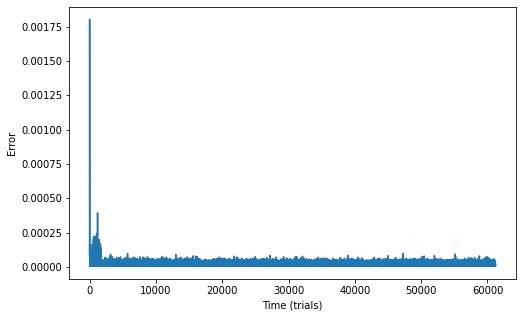

In [22]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(list(range(len(record_avgsqerr))), record_avgsqerr)
ax.set_xlabel("Time (update intervals)")
ax.set_ylabel("Error")
plt.show()
# might be nicer to show this after smoothing e.g. with a moving average

# Testing

In [30]:
ssa_input_init = {"startSpike": test_start_spike,
                  "endSpike": test_end_spike,
                  "z": 0.0,
                  "z_tilda": 0.0}

model = genn_model.GeNNModel(precision="float", model_name="train", time_precision="double")
model.dT = 1.0 * TIME_FACTOR

inp = model.add_neuron_population("inp", N_INPUT, ssa_input_model, SSA_INPUT_PARAMS, ssa_input_init)
inp.set_extra_global_param("spikeTimes", test_spikeTimes)

hid = model.add_neuron_population("hid", N_HIDDEN, hidden_model, HIDDEN_PARAMS, hidden_init)

out = model.add_neuron_population("out", N_OUTPUT, output_model_classification, OUTPUT_PARAMS,
                                  output_init_classification)

inp2hid = model.add_synapse_population("inp2hid", "DENSE_INDIVIDUALG",
                                               genn_wrapper.NO_DELAY,
                                               inp, hid,
                                               "StaticPulse", {}, {"g": inp2hid_to_test}, {},
                                               {},
                                               "ExpCurr", {"tau": 5.0}, {})

hid2out = model.add_synapse_population("hid2out", "DENSE_INDIVIDUALG",
                                               genn_wrapper.NO_DELAY,
                                               hid, out,
                                               "StaticPulse", {}, {"g": hid2out_to_test}, {},
                                               {},
                                               "ExpCurr", {"tau": 5.0}, {})

model.build()
model.load()

In [31]:
print("Testing...")

num_correct = 0

for sample_idx in range(TEST_SAMPLES):
    
    if sample_idx % 100 == 0:
        print("Sample: " + str(sample_idx))
    
    test_target = y_test[sample_idx]  # target class 0 to 9
    test_target_spikes = []
    test_non_target_spikes = []

    test_steps = int((STIMULUS_TIMESTEPS + WAIT_TIMESTEPS + ITI) / TIME_FACTOR)

    for test_t in range(test_steps):
        
        model.step_time()

        if test_t < int((STIMULUS_TIMESTEPS + WAIT_TIMESTEPS) / TIME_FACTOR):
            model.pull_current_spikes_from_device("out")
            if test_target in out.current_spikes:
                test_target_spikes.append(model.t)
            else:
                if len(out.current_spikes) != 0:
                    test_non_target_spikes.append(model.t)

    if len(test_target_spikes) != 0 and len(test_non_target_spikes) == 0:
        num_correct += 1

accuracy = num_correct / TEST_SAMPLES
print("Accuracy: " + str(accuracy))

Testing...
Sample: 0
Sample: 100
Sample: 200
Sample: 300
Sample: 400
Sample: 500
Sample: 600
Sample: 700
Sample: 800
Sample: 900
Sample: 1000
Sample: 1100
Sample: 1200
Sample: 1300
Sample: 1400
Sample: 1500
Sample: 1600
Sample: 1700
Sample: 1800
Sample: 1900
Sample: 2000
Sample: 2100
Sample: 2200
Sample: 2300
Sample: 2400
Sample: 2500
Sample: 2600
Sample: 2700
Sample: 2800
Sample: 2900
Sample: 3000
Sample: 3100
Sample: 3200
Sample: 3300
Sample: 3400
Sample: 3500
Sample: 3600
Sample: 3700
Sample: 3800
Sample: 3900
Sample: 4000
Sample: 4100
Sample: 4200
Sample: 4300
Sample: 4400
Sample: 4500
Sample: 4600
Sample: 4700
Sample: 4800
Sample: 4900
Sample: 5000
Sample: 5100
Sample: 5200
Sample: 5300
Sample: 5400
Sample: 5500
Sample: 5600
Sample: 5700
Sample: 5800
Sample: 5900
Sample: 6000
Sample: 6100
Sample: 6200
Sample: 6300
Sample: 6400
Sample: 6500
Sample: 6600
Sample: 6700
Sample: 6800
Sample: 6900
Sample: 7000
Sample: 7100
Sample: 7200
Sample: 7300
Sample: 7400
Sample: 7500
Sample: 7600
